

Import common package

In [1]:

import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

Import homemade code

In [2]:

from qcat.state_discrimination.discriminator import train_GMModel
from qcat.visualization.readout_fidelity import plot_readout_fidelity


File formate translate (QM)

In [3]:
dataset = xr.open_dataset(r"d:\Data\5Q4C0510_DR1_scalinQ\20240617_1010_ro_fidelity_q4_xy.nc")
print(dataset)
transposed_data = dataset.transpose("mixer", "state", "index")

format_data = {}
for ro_name, data in transposed_data.data_vars.items(): 
    new_data = data.values*1000
    format_data[ro_name] = new_data
    print(ro_name)


<xarray.Dataset>
Dimensions:  (mixer: 2, index: 10000, state: 2)
Coordinates:
  * mixer    (mixer) <U1 'I' 'Q'
  * index    (index) int32 0 1 2 3 4 5 6 ... 9993 9994 9995 9996 9997 9998 9999
  * state    (state) int32 0 1
Data variables:
    q0_ro    (mixer, index, state) float64 ...
    q1_ro    (mixer, index, state) float64 ...
    q2_ro    (mixer, index, state) float64 ...
    q3_ro    (mixer, index, state) float64 ...
    q4_ro    (mixer, index, state) float64 ...
q0_ro
q1_ro
q2_ro
q3_ro
q4_ro


File formate translate (Qblox)

In [16]:
dataset = xr.open_dataset(r"D:\Data\format_test\DR1q0_SingleShot_44GHz.nc")
# print(dataset)
shot_num = dataset["g"].values.shape[-1]
combined_array = np.array([dataset["g"].values,dataset["e"].values])
format_dataset = xr.Dataset(
    {"q0_ro":(["state", "mixer", "index"], combined_array)},
    coords={ "mixer":np.array(["I","Q"]), "state":np.array([0,1]), "index": np.arange(shot_num) }
)
format_dataset = format_dataset.transpose("mixer", "state", "index")

print(format_dataset)

format_data = {}
format_data["q0_ro"] = format_dataset["q0_ro"].values*1000



<xarray.Dataset>
Dimensions:  (state: 2, mixer: 2, index: 5000)
Coordinates:
  * mixer    (mixer) <U1 'I' 'Q'
  * state    (state) int32 0 1
  * index    (index) int32 0 1 2 3 4 5 6 ... 4993 4994 4995 4996 4997 4998 4999
Data variables:
    q0_ro    (mixer, state, index) float64 0.0008809 0.002007 ... -0.003988


Create Discriminator object to analyze data

In [4]:

ro_name = "q4_ro"

training_data = format_data[ro_name] #your (2,2,N) data to train
dist_model = train_GMModel(training_data)
# For loop start here
analysis_data = format_data #your (2,2,N) data to analysis

new_data = np.moveaxis( analysis_data[ro_name] ,1,0)
p0_pop = dist_model.get_state_population(new_data[0].transpose())
p1_pop = dist_model.get_state_population(new_data[1].transpose())
print(p0_pop, p1_pop)

from qcat.state_discrimination.discriminator import train_1DGaussianModel, get_proj_distance, get_probability, p01_to_Teff

centers, sigmas = dist_model.output_1D_paras()
train_data_proj = get_proj_distance(centers.transpose(), analysis_data[ro_name])
pos = get_proj_distance(centers.transpose(),centers.transpose())
trained_1DGModel = train_1DGaussianModel( train_data_proj.flatten(), (pos,sigmas) )
# # Histogram plot
bin_center, hist_0, p0_result = trained_1DGModel.fit_distribution(train_data_proj[0])
# print(p0_result.fit_report())
probability = get_probability(p0_result)
p01 = probability[1]
print(p01)
effective_T = p01_to_Teff(p01, 4.955e9)
print(effective_T)
# For loop end here


[8969 1031] [1193 8807]
guess (array([-0.05660084,  0.07007789]), array([0.02381473, 0.02455798]))
mu, sigma [-0.05660084  0.07007789] [0.02381473 0.02455798]
BB [-0.05660084  0.07007789] [0.02381473 0.02455798]
est_peak_h 41.345629545443934
AAAA (50,) 0.007638555836224137
0.10381724764052101
0.1103298257475261


Plot fidelity

guess (array([-0.05660084,  0.07007789]), array([0.02381473, 0.02455798]))
mu, sigma [-0.05660084  0.07007789] [0.02381473 0.02455798]
BB [-0.05660084  0.07007789] [0.02381473 0.02455798]
est_peak_h 41.345629545443934
AAAA (50,) 0.007638555836224137
0.10381724764052101


c:\Users\shiau\.conda\envs\PYQUM-server-offline\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


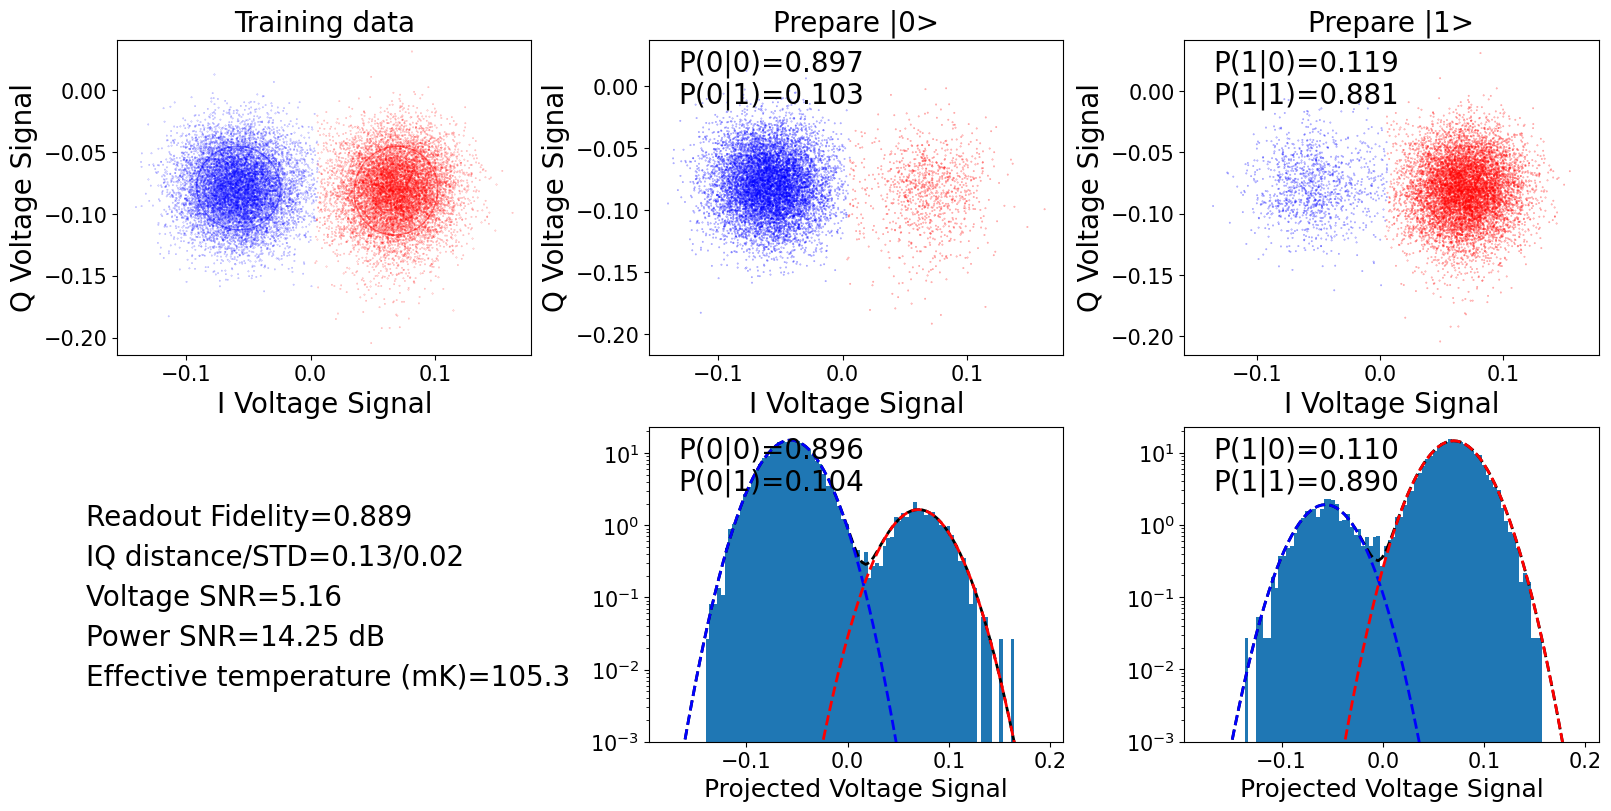

In [5]:

single_name = ro_name
# for ro_name, data in format_data.items(): 
for ro_name, data in [(single_name, format_data[single_name])]:
    plot_readout_fidelity(data, 4.73e9)

plt.show()
